In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
#from ultralytics import YOLO

In [3]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

In [4]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [6]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [7]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

def bg_inpaint(bg,mask,inpaint_radius=3,inpainting=cv2.INPAINT_TELEA):
    #cv2.INPAINT_TELEA or cv2.INPAINT_NS)
    bg_inpainted = cv2.inpaint((bg[:,:,0:3]*255).astype(np.uint8),mask,inpaint_radius,inpainting)
    return bg_inpainted

In [8]:
def random_jiggle_mask(all_mask,inteligent_random=True):
    min_y, min_x = np.argwhere(all_mask).min(axis=0)
    max_y, max_x = np.argwhere(all_mask).max(axis=0)
    dist_x = max_x-min_x
    dist_y = max_y-min_y
    avail_x = np.arange(0,all_mask.shape[1]-dist_x)
    avail_y = np.arange(0,all_mask.shape[0]-dist_y)
    
    #inteligent_random = True
    if inteligent_random==True:
        prob_x = np.ones(len(avail_x))
        prob_x[((avail_x>=min_x-dist_x)*(avail_x<=max_x))]=.001

        prob_y = np.ones(len(avail_y))
        prob_y[((avail_y>=min_y)*(avail_y<=max_y))]=.001

        choose_x = random.choices(avail_x,weights=prob_x,k=1)[0]
        choose_y = random.choices(avail_y,weights=prob_y,k=1)[0]
    else:        
        choose_x = random.choice(avail_x)
        choose_y = random.choice(avail_y)
    
    e_mask = np.zeros(all_mask.shape)
    blob = all_mask[min_y:max_y,min_x:max_x]
    e_mask[choose_y:choose_y+dist_y,choose_x:choose_x+dist_x] = blob
    return e_mask.astype(np.uint8)

In [9]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_frames/video/'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/'

In [10]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
folders[0:5]

['ALS_IceBucket_Challenge',
 'CPR',
 'abseiling',
 'add_new_car_tire',
 'adjusting_glasses']

In [11]:
len(folders)

500

In [12]:
videos = []
for folder in folders:
    conts = os.listdir(os.path.join(indir,folder))
    conts = [os.path.join(indir,folder,cont) for cont in conts if not cont.startswith('.')]
    conts.sort()
    videos.append(conts)

In [13]:
def get_mask_resized(im,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(im.shape[1],im.shape[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [14]:
def cut_to_mask(im,mask):
    im2 = im.copy()
    for c in range(im2.shape[-1]):
        im2[:,:,c][mask==0]=0
        
    return im2

In [15]:
def cut_to_mask_inv(im,mask):
    im2 = im.copy()
    for c in range(im2.shape[-1]):
        im2[:,:,c][mask!=0]=0
        
    return im2

In [16]:
folder = 215
video = 0

In [17]:
# folder = random.choice(np.arange(len(folders)))
# folder

In [18]:
print(videos[folder][video])

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_frames/video/hold_baby/hold_baby_000


In [19]:
frames_filenames = [frame for frame in os.listdir(videos[folder][video]) if frame.endswith('.png')]
masks_filenames = [mask for mask in os.listdir(videos[folder][video]) if mask.endswith('_masks.npy')]
box_filenames = [box for box in os.listdir(videos[folder][video]) if box.endswith('_box.npy')]

print(f'{len(frames_filenames)}|{len(masks_filenames)}')

assert len(frames_filenames)==len(masks_filenames),'mismatch'
assert len(frames_filenames)==len(box_filenames),'mismatch'

frames_filenames.sort()
masks_filenames.sort()
box_filenames.sort()

nframes = len(frames_filenames)

29|29


In [20]:
frames = [plt.imread(os.path.join(videos[folder][video],frames_filenames[f])) for f in range(nframes)]
masks = [np.load(os.path.join(videos[folder][video],masks_filenames[f])) for f in range(nframes)]
boxes = [np.load(os.path.join(videos[folder][video],box_filenames[f])) for f in range(nframes)]

In [21]:
yolo_labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

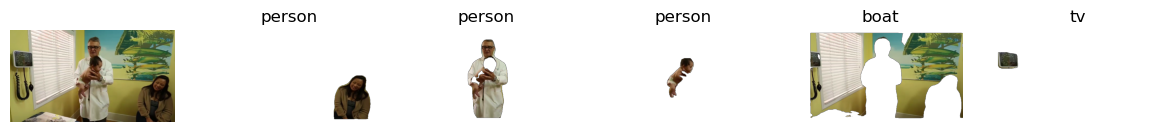

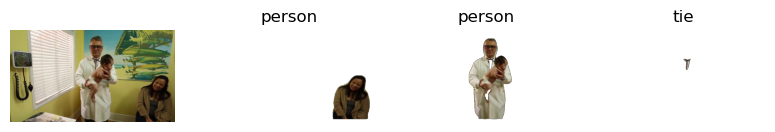

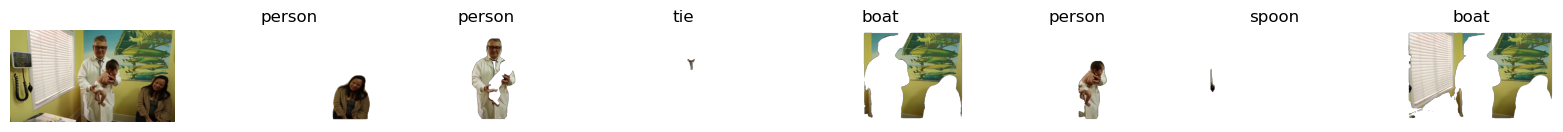

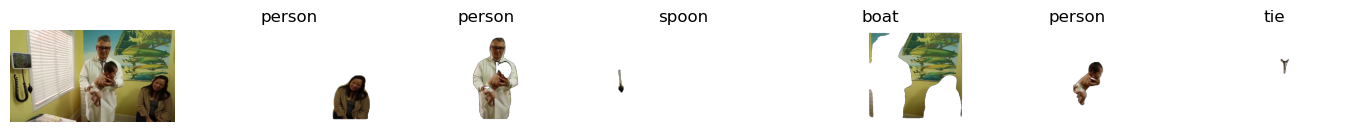

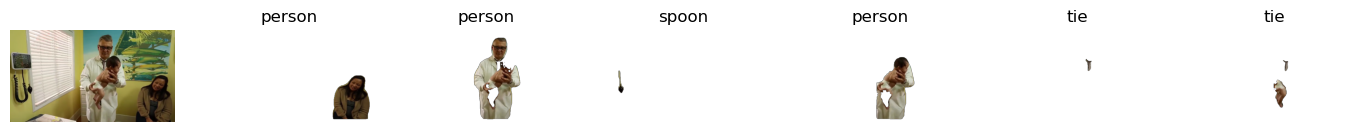

In [22]:
for c,f in enumerate(np.linspace(0,nframes-1,5).astype(int)):
    plt.figure(figsize=((25,5)))
    plt.subplot(1,10,1)
    plt.imshow(frames[f])
    plt.axis('off');

    for i in range(min((masks[f].shape[0],9))):
        plt.subplot(1,10,2+i)
        plt.imshow(cut_to_mask(frames[f],get_mask_resized(frames[f],masks[f][i,:,:])))
        plt.title(yolo_labels[int(boxes[f][i,-1])])
        plt.axis('off')

In [23]:
first_frame_lbls = np.array([yolo_labels[int(boxes[0][i,-1])] for i in range(boxes[0].shape[0])])
item_person_idx = np.nonzero(first_frame_lbls=='person')[0][0]
print(item_person_idx)

0


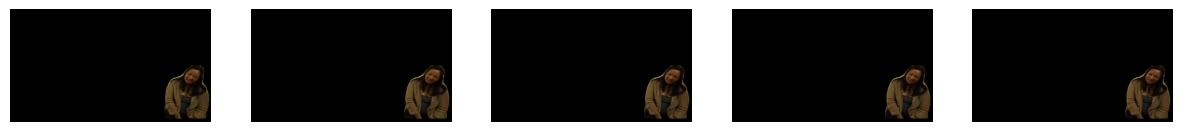

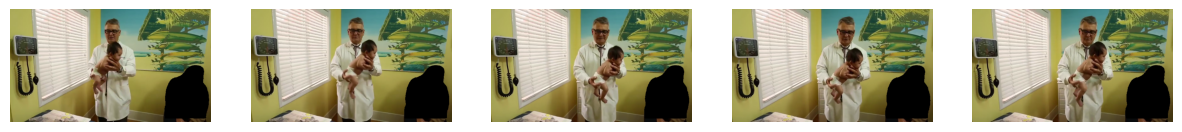

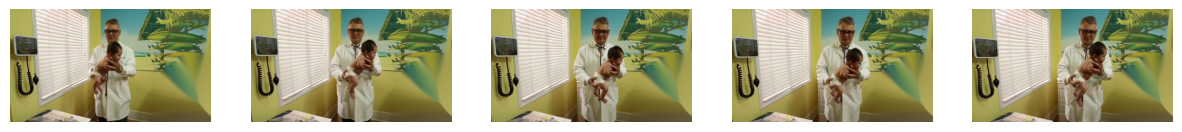

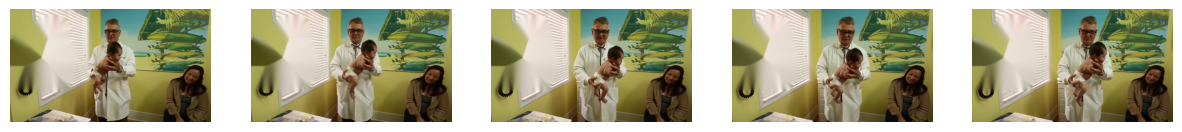

done


In [24]:
these_masks = []
frame_id = 0
#frame = frames[f]
n_items = masks[0].shape[0]
#print(n_items)

#for this_item in range(n_items):
for this_item in [item_person_idx]: # First item is _usually main person_
    mask = masks[0][this_item,:,:]
    these_masks = []
    these_masks.append(mask)
    for j in range(1,nframes):
        mask_sim = np.array([np.corrcoef(masks[j][i,:,:].flatten(),mask.flatten())[0,1] for i in range(masks[j].shape[0])])
        #print(mask_sim)
        if (mask_sim > .5).sum() < 1:
            next_mask = np.zeros(mask.shape)
            mask = next_mask
        else:
            next_mask = masks[j][np.argmax(mask_sim),:,:]
            mask = next_mask

        these_masks.append(mask)

    arr = np.array([cut_to_mask(frames[i],get_mask_resized(frames[i],these_masks[i])) for i in range(len(frames))])
    arr2 = np.array([cut_to_mask_inv(frames[i],get_mask_resized(frames[i],these_masks[i])) for i in range(len(frames))]) 
    
    ## Inpainted videos (CV2)
    masks_all = np.array([get_mask_resized(frames[i],these_masks[i]) for i in range(len(frames))])
    all_mask = masks_all.sum(axis=0)
    all_mask[all_mask>0] = 255
    all_mask = all_mask.astype(np.uint8)
    
    inflate_radius = 15
    inpain_radius = 5
    
    arr3 = [bg_inpaint(cut_to_mask_inv(frames[i],all_mask),inflate_mask(all_mask,radius=inflate_radius),inpaint_radius=inpain_radius,inpainting=cv2.INPAINT_TELEA) for i in range(len(frames))]
    arr3 = np.array(arr3)
    
    randmask = random_jiggle_mask(all_mask)
    arr4 = [bg_inpaint(cut_to_mask_inv(frames[i],randmask),inflate_mask(randmask,radius=inflate_radius),inpaint_radius=inpain_radius,inpainting=cv2.INPAINT_TELEA) for i in range(len(frames))]
    arr4 = np.array(arr4)
    
        
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr[int(i),:,:,0:3])
    plt.show()
    
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr2[int(i),:,:,0:3])
    plt.show()
    
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr3[int(i),:,:,0:3])
    plt.show()
    
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr4[int(i),:,:,0:3])
    plt.show()

    
    ### ALSO SAVE IN yolo_seg folder
    do_save = True
    if do_save:
        temp = f'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/{folders[folder]}'
        safe_mkdir(temp)

        ofn = os.path.join(temp,frames_filenames[0].replace('_000.png',f'_item_{0}_fwd_seg.mp4'))
        save_video(arr[:,:,:,0:3]*255,ofn)

        #temp = '/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg'
        ofn = os.path.join(temp,frames_filenames[0].replace('_000.png',f'_item_{0}_inv_seg.mp4'))
        save_video(arr2[:,:,:,0:3]*255,ofn)

        ofn = os.path.join(temp,frames_filenames[0].replace('_000.png',f'_item_{0}_inp_seg.mp4'))
        save_video(arr3[:,:,:,0:3],ofn)
        
        #ofn = os.path.join(temp,frames_filenames[0].replace('_000.png',f'_item_{this_item}_inp_rnd.mp4'))
        #save_video(arr4[:,:,:,0:3],ofn)

        np.save(os.path.join(temp,frames_filenames[0].replace('_000.png',f'_item_{0}_masks.npy')),np.array(these_masks))
        
        # Copy over the original
        shutil.copyfile(src=os.path.join(videos[folder][video],frames_filenames[0].replace('_000.png','.mp4')),dst=os.path.join(temp,frames_filenames[0].replace('_000.png','.mp4')))
    
print('done')

(-0.5, 639.5, 359.5, -0.5)

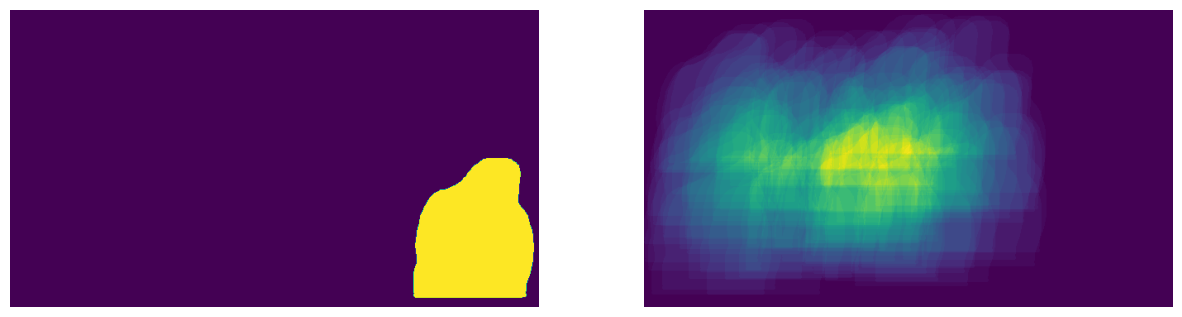

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(all_mask);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.array([random_jiggle_mask(all_mask) for _ in range(100)]).mean(axis=0));plt.axis('off')